# Import library

In [8]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms.functional import to_pil_image

from sklearn.metrics import confusion_matrix

# Load dataset

In [9]:
#rom google.colab import drive
#drive.mount('/content/drive')

In [10]:
def data_augmentation(rot=25, crop=True, hflip=True, vflip=True):
    transform_list = []
    # if rot:
    #     transform_list.append(transforms.RandomRotation(rot))
    # if hflip:
    #     transform_list.append(transforms.RandomHorizontalFlip())
    # if vflip:
    #     transform_list.append(transforms.RandomVerticalFlip())

    transform_list.append(transforms.ToTensor())
    transform_list.append(transforms.Normalize((0.1307,), (0.3081,)))

    return transforms.Compose(transform_list)

In [11]:
class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        data = csv_file.values
        self.labels = data[:, 0]
        self.images = data[:, 1:].reshape(-1, 28, 28).astype(np.uint8)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]
        image = Image.fromarray(image)  # Convert numpy to PIL

        if self.transform:
            image = self.transform(image)

        return image, label

# Load data from csv
from torch.utils.data import random_split

#train_csv = pd.read_csv("drive/MyDrive/CS3244_Group 4/data/fashion-mnist_train.csv")
#test_csv = pd.read_csv("drive/MyDrive/CS3244_Group 4/data/fashion-mnist_test.csv")
train_csv = pd.read_csv("../data/fashion-mnist_train.csv")
test_csv = pd.read_csv("../data/fashion-mnist_test.csv")
train_set = FashionMNISTDataset(train_csv, transform = data_augmentation())
test_set = FashionMNISTDataset(test_csv, transform =  data_augmentation())
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_set, val_set = random_split(train_set, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
val_loader = DataLoader(val_set, batch_size = 32, shuffle=True)

print("Train set size:", len(train_set))
print("Validation set size:", len(val_set))
print("Test set size:", len(test_set))

#class mapping
class_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

Train set size: 48000
Validation set size: 12000
Test set size: 10000


# Model summary
* 5 convolutional blocks (ending with 512 feature maps and 7x7 spatial size)
* 2 fully connected blocks of size 4096
* Final output layer to 10 classes

In [12]:
class DNNv1(nn.Module):
    def __init__(self, latent_dim=20, num_classes=10):
        super(DNNv1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 400),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )

        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        class_logits = self.classifier(z)
        return x_recon, mu, logvar, class_logits

# Define Hyper parameters


In [13]:
def loss_function(recon_x, x, mu, logvar, logits, targets):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    cls_loss = F.cross_entropy(logits, targets)
    return recon_loss + kl_loss + cls_loss, recon_loss, kl_loss, cls_loss

def evaluate(model, loader):
    model.eval()
    loss_sum, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            recon_x, mu, logvar, logits = model(x)
            loss, _, _, _ = loss_function(recon_x, x, mu, logvar, logits, y)
            loss_sum += loss.item()
            correct += (logits.argmax(dim=1) == y).sum().item()
            total += y.size(0)
    return loss_sum / total, correct / total


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DNNv1().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training

In [14]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

train_losses, val_losses, val_accuracies = [], [], []
epochs = 25
for epoch in range(1, epochs+1):
    ## Train Step
    model.train()
    train_loss_epoch = 0

    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        recon_x, mu, logvar, logits = model(x)
        loss, _, _, _ = loss_function(recon_x, x, mu, logvar, logits, y)
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item()

    avg_train_loss = train_loss_epoch / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    print(f"[Epoch {epoch}] Train Loss: {avg_train_loss:.4f}")

    ## Validation Step
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(DEVICE), y_val.to(DEVICE)
            recon_x, mu, logvar, logits = model(x_val)
            loss, _, _, _ = loss_function(recon_x, x_val, mu, logvar, logits, y_val)
            val_loss += loss.item()

            _, predictions = torch.max(logits, dim=1)
            correct += (predictions == y_val).sum().item()
            total += y_val.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"[Epoch {epoch}] Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc * 100:.2f}%")


[Epoch 1] Train Loss: 516.9397
[Epoch 1] Val Loss: 492.4372 | Val Acc: 76.64%
[Epoch 2] Train Loss: 487.1063
[Epoch 2] Val Loss: 481.1427 | Val Acc: 79.17%
[Epoch 3] Train Loss: 480.2011
[Epoch 3] Val Loss: 477.9110 | Val Acc: 80.71%
[Epoch 4] Train Loss: 476.7740
[Epoch 4] Val Loss: 474.4978 | Val Acc: 81.47%
[Epoch 5] Train Loss: 474.9883
[Epoch 5] Val Loss: 473.3734 | Val Acc: 82.47%
[Epoch 6] Train Loss: 473.5984
[Epoch 6] Val Loss: 472.4375 | Val Acc: 82.36%
[Epoch 7] Train Loss: 472.9431
[Epoch 7] Val Loss: 472.6107 | Val Acc: 82.27%
[Epoch 8] Train Loss: 6405.0964
[Epoch 8] Val Loss: 472.5930 | Val Acc: 82.31%
[Epoch 9] Train Loss: 472.1752
[Epoch 9] Val Loss: 471.0406 | Val Acc: 82.48%
[Epoch 10] Train Loss: 471.4998
[Epoch 10] Val Loss: 471.0268 | Val Acc: 82.79%
[Epoch 11] Train Loss: 471.0025
[Epoch 11] Val Loss: 469.7748 | Val Acc: 83.08%
[Epoch 12] Train Loss: 470.7216
[Epoch 12] Val Loss: 470.3433 | Val Acc: 83.00%
[Epoch 13] Train Loss: 470.5253
[Epoch 13] Val Loss: 470.

#Test

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import torch.nn.functional as F
import numpy as np

all_preds = []
all_probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(DEVICE)
        labels = labels.to(DEVICE)

        _, _, _, logits = model(data)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

###Confusion Matrix

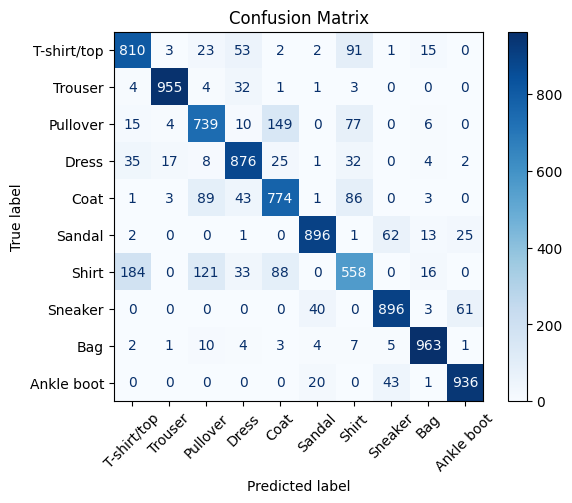

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_names.values()))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

###Precision, Recall, F1-score (per class)

In [17]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=list(class_names.values())))

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.77      0.81      0.79      1000
     Trouser       0.97      0.95      0.96      1000
    Pullover       0.74      0.74      0.74      1000
       Dress       0.83      0.88      0.85      1000
        Coat       0.74      0.77      0.76      1000
      Sandal       0.93      0.90      0.91      1000
       Shirt       0.65      0.56      0.60      1000
     Sneaker       0.89      0.90      0.89      1000
         Bag       0.94      0.96      0.95      1000
  Ankle boot       0.91      0.94      0.92      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



###Top-k Accuracy, k = 3

In [18]:
topk = 3
topk_correct = 0
total = 0

model.eval()
with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = model(data)[-1]
        _, topk_preds = logits.topk(topk, dim=1)  # [batch, topk]
        match = topk_preds.eq(labels.view(-1, 1))  # [batch, topk]

        topk_correct += match.any(dim=1).sum().item()
        total += labels.size(0)

topk_acc = topk_correct / total * 100
print(f"Top-{topk} Accuracy: {topk_acc:.2f}%")

Top-3 Accuracy: 98.52%


###ROC-AUC / PR-AUC

In [19]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# One-hot encode labels
y_true_bin = label_binarize(all_labels, classes=list(range(10)))
roc_auc = roc_auc_score(y_true_bin, all_probs, average="macro", multi_class="ovr")
print(f"Multiclass ROC-AUC (macro avg): {roc_auc:.4f}")

Multiclass ROC-AUC (macro avg): 0.9850
